1.  State the problem and its significance.

Very recently US gas stations were hit a ransomware attack that cause mass panic. You can read the full story [here](https://www.bloomberg.com/news/articles/2021-06-22/colonial-pipeline-is-sued-in-proposed-gas-station-class-action). The goal of this project is to show how a ransomeware attack causes longer wait times.

2.  Provide a flow-chart model.

![](flow_chart.png)

The gas station has a limited number of gas pumps that share a common fuel reservoir. Cars randomly arrive at the gas station, request one of the fuel pumps and start refueling from that reservoir. A gas station control process observes the gas station's fuel level and calls a tank truck for refueling if the station's level drops below a threshold. If a randomware attack happend the refueling speed drops to represent a slow down.


3.  Simulate the process for the appropriate number of iterations (justify)


4.  Justify the validity of the model and discuss how you verified it.

 

In [237]:
import itertools
import random

import simpy
import matplotlib.pyplot as plt
import pandas as pd

RANDOM_SEED = 42
GAS_STATION_SIZE = 200     # liters
THRESHOLD = 15             # Threshold for calling the tank truck (in %)
FUEL_TANK_SIZE = 50        # liters
FUEL_TANK_LEVEL = [5, 10]  # Min/max levels of fuel tanks (in liters)
REFUELING_SPEED = 5       # liters / second
TANK_TRUCK_TIME = 300      # Seconds it takes the tank truck to arrive
T_INTER = [10, 100]        # Create a car every [min, max] seconds
SIM_TIME = 10000          # Simulation time in seconds
CAR_WAITING_TIMES = []
TRUCK_WAITING_TIMES = []
RANSOME_TIMES = []

In [238]:
def car(name, env, gas_station, fuel_pump):
    """A car arrives at the gas station for refueling.

    It requests one of the gas station's fuel pumps and tries to get the
    desired amount of gas from it. If the stations reservoir is
    depleted, the car has to wait for the tank truck to arrive.

    """
    fuel_tank_level = random.randint(*FUEL_TANK_LEVEL)
    print('Fuel tank level at {}'.format(fuel_tank_level))
    print('{} arriving at gas station at {}'.format(name, env.now))
    with gas_station.request() as req:
        start = env.now
        # Request one of the gas pumps
        yield req

        # Get the required amount of fuel
        liters_required = FUEL_TANK_SIZE - fuel_tank_level
        yield fuel_pump.get(liters_required)

        # The "actual" refueling process takes some time
        yield env.timeout(liters_required / REFUELING_SPEED)
        end = env.now
        
        # Collect total time for refueling
        CAR_WAITING_TIMES.append({'car': name, 'time': end-start, 'stamp': int(env.now)})
        
        print('{} finished refueling in {} seconds.'.format(name, env.now - start))

In [239]:
def gas_station_control(env, fuel_pump, REFUELING_SPEED):
    """Periodically check the level of the *fuel_pump* and call the tank
    truck if the level falls below a threshold."""
    while True:
        if fuel_pump.level / fuel_pump.capacity * 100 < THRESHOLD:
            env.process(check_ransomware_attack(env, REFUELING_SPEED))
            # We need to call the tank truck now!
            print('Calling tank truck at {}'.format(env.now))
            # Wait for the tank truck to arrive and refuel the station
            
            TRUCK_WAITING_TIMES.append({'stamp': env.now, 'truck': 1})
            yield env.process(tank_truck(env, fuel_pump))

        yield env.timeout(10)  # Check every 10 seconds

In [240]:
def tank_truck(env, fuel_pump):
    """Arrives at the gas station after a certain delay and refuels it."""
    yield env.timeout(TANK_TRUCK_TIME)
    print('Tank truck arriving at time {}'.format(env.now))
    ammount = fuel_pump.capacity - fuel_pump.level
    print('Tank truck refuelling {} liters.'.format(ammount))
    yield fuel_pump.put(ammount)

In [241]:
def car_generator(env, gas_station, fuel_pump):
    """Generate new cars that arrive at the gas station."""
    for i in itertools.count():
        yield env.timeout(random.randint(*T_INTER))
        env.process(car('Car {}'.format(i), env, gas_station, fuel_pump))

In [242]:
def check_ransomware_attack(env, REFUELING_SPEED):
    """
    A rare ransome ware attack that lowers the available number of pumps for gas
    the loss of pumps is reflected in the lowering of REFUELING_SPEED
    """
    if random.uniform(0, 1) > 0.5:
        print('The gas station was hit by a ransomware attack at {}'.format(env.now))
        REFUELING_SPEED -= 1
        RANSOME_TIMES.append({'stamp': env.now, 'attack': 1})
        yield env.timeout(10)
        print('Ransomware attack fixed {}'.format(env.now))

In [243]:
# Setup and start the simulation
print('Gas Station refuelling')
random.seed(RANDOM_SEED)

# Create environment and start processes
env = simpy.Environment()
gas_station = simpy.Resource(env, 1)
fuel_pump = simpy.Container(env, GAS_STATION_SIZE, init=GAS_STATION_SIZE)

env.process(gas_station_control(env, fuel_pump, REFUELING_SPEED))
env.process(car_generator(env, gas_station, fuel_pump))
env.run(until=SIM_TIME)

Gas Station refuelling
Fuel tank level at 5
Car 0 arriving at gas station at 91
Car 0 finished refueling in 9.0 seconds.
Fuel tank level at 6
Car 1 arriving at gas station at 115
Car 1 finished refueling in 8.799999999999997 seconds.
Fuel tank level at 6
Car 2 arriving at gas station at 160
Car 2 finished refueling in 8.800000000000011 seconds.
Fuel tank level at 10
Car 3 arriving at gas station at 198
Calling tank truck at 200
The gas station was hit by a ransomware attack at 200
Car 3 finished refueling in 8.0 seconds.
Ransomware attack fixed 210
Fuel tank level at 5
Car 4 arriving at gas station at 221
Fuel tank level at 8
Car 5 arriving at gas station at 300
Fuel tank level at 5
Car 6 arriving at gas station at 385
Fuel tank level at 6
Car 7 arriving at gas station at 399
Fuel tank level at 9
Car 8 arriving at gas station at 420
Fuel tank level at 5
Car 9 arriving at gas station at 459
Tank truck arriving at time 500
Tank truck refuelling 173 liters.
Car 4 finished refueling in 288

In [244]:
cdf = pd.DataFrame(CAR_WAITING_TIMES)

In [245]:
tdf = pd.DataFrame(TRUCK_WAITING_TIMES)

In [246]:
tdf

,stamp,truck
0,200,1
1,530,1


In [247]:
rdf = pd.DataFrame(RANSOME_TIMES)

In [248]:
rdf

,stamp,attack
0,200,1
1,530,1


In [249]:
df = pd.concat((i.set_index('stamp') for i in [cdf, tdf, rdf]),axis=1).reset_index().assign(
        truck=lambda x: x['truck'].fillna(0),
        attack=lambda x: x['attack'].fillna(0),
        car=lambda x: x['car'].ffill(),
        time=lambda x: x['time'].ffill())

In [250]:
df.head()

,stamp,car,time,truck,attack
0,100,Car 0,9.0,0.0,0.0
1,123,Car 1,8.8,0.0,0.0
2,168,Car 2,8.8,0.0,0.0
3,200,Car 2,8.8,1.0,1.0
4,206,Car 3,8.0,0.0,0.0


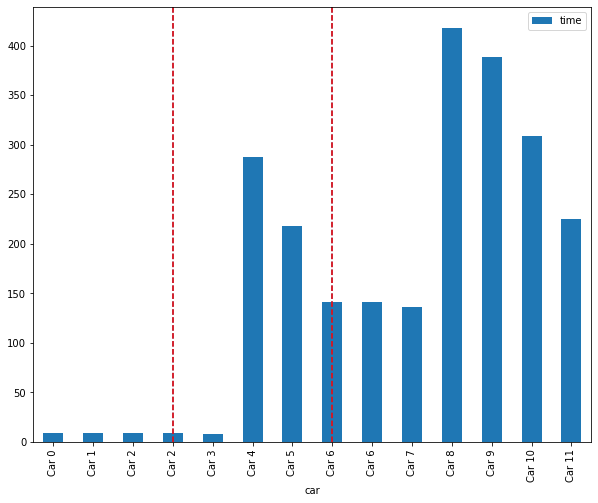

In [251]:
fig, ax = plt.subplots()
df.plot(x='car', y='time', kind='bar', figsize=(10,8), ax=ax)

for i in df[df['truck'].eq(1)]['car'].values.tolist():
    ax.axvline(x=int(i.split(' ')[-1])+1, linestyle='--')
    
for i in df[df['attack'].eq(1)]['car'].values.tolist():
    ax.axvline(x=int(i.split(' ')[-1])+1, linestyle='--', color='red')

In [ ]:
df.plot(x=)